In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.utils.class_weight import compute_class_weight

In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain columns:\n", train.columns)
print("\nTrain info:")
train.info()

Train shape: (18524, 9)
Test shape: (6175, 8)

Train columns:
 Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-n

In [5]:
print("\nMissing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())


Missing values in train:
 id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Missing values in test:
 id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


In [6]:
print("\nTrain describe:\n", train.describe())


Train describe:
                  id  Time_spent_Alone  Social_event_attendance  Going_outside  \
count  18524.000000      17334.000000             17344.000000   17058.000000   
mean    9261.500000          3.137764                 5.265106       4.044319   
std     5347.562529          3.003786                 2.753359       2.062580   
min        0.000000          0.000000                 0.000000       0.000000   
25%     4630.750000          1.000000                 3.000000       3.000000   
50%     9261.500000          2.000000                 5.000000       4.000000   
75%    13892.250000          4.000000                 8.000000       6.000000   
max    18523.000000         11.000000                10.000000       7.000000   

       Friends_circle_size  Post_frequency  
count         17470.000000    17260.000000  
mean              7.996737        4.982097  
std               4.223484        2.879139  
min               0.000000        0.000000  
25%               5.000000 


Target distribution:
 Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64


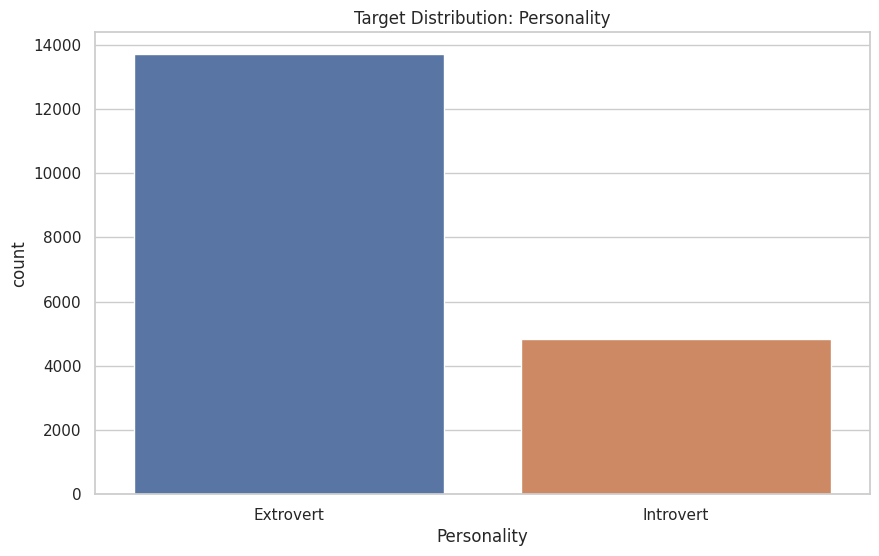

In [7]:
print("\nTarget distribution:\n", train['Personality'].value_counts())
sns.countplot(data=train, x='Personality')
plt.title('Target Distribution: Personality')
plt.show()

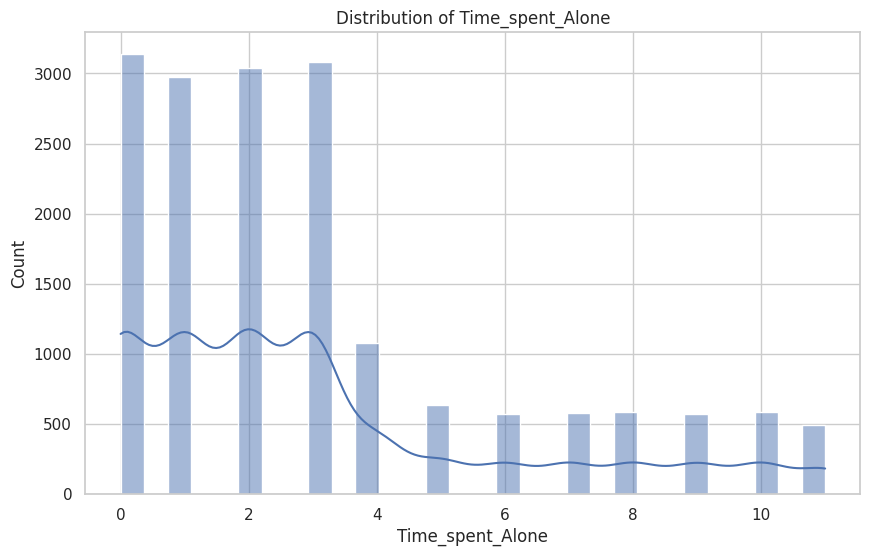

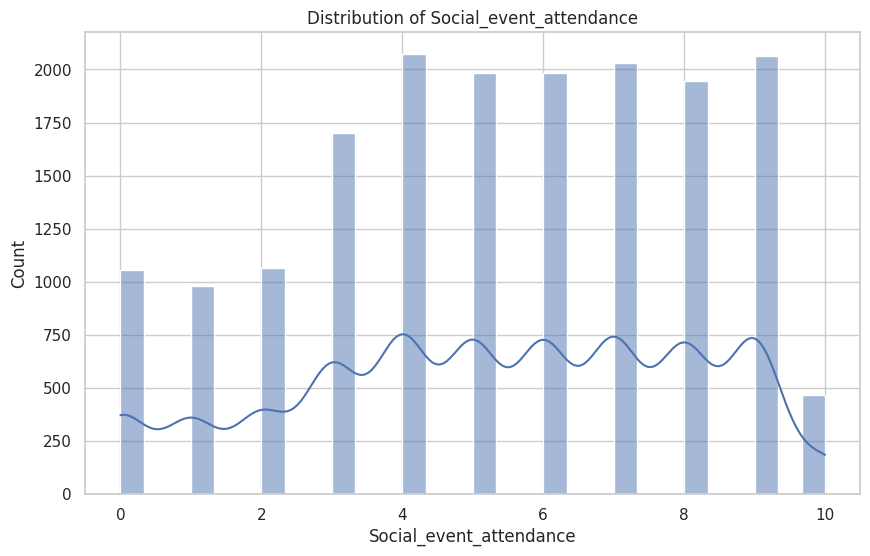

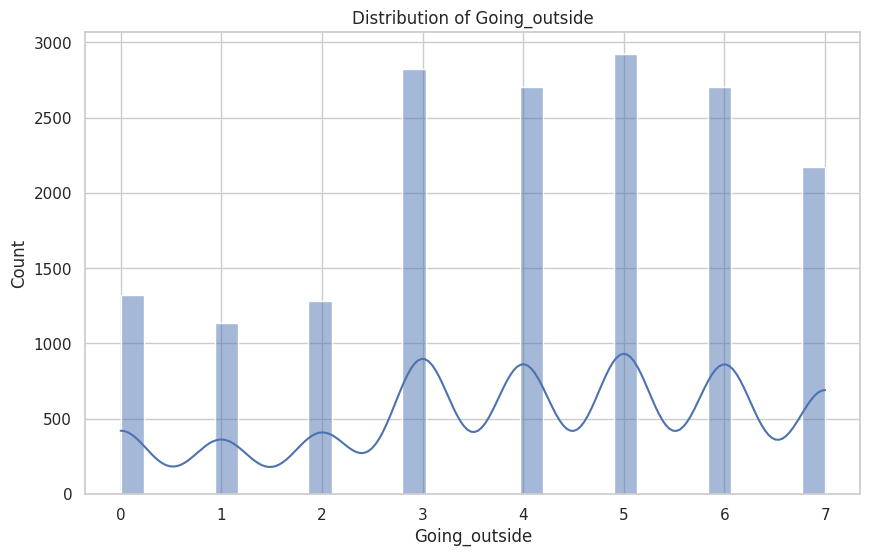

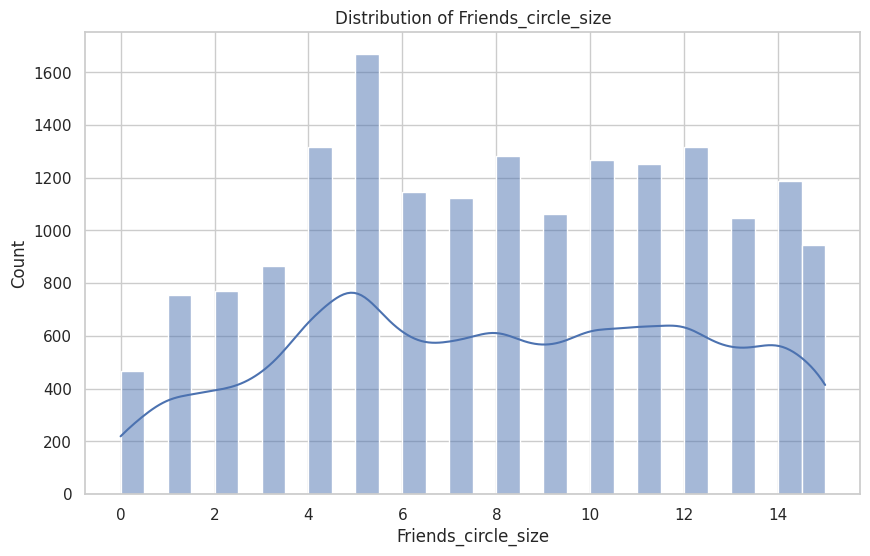

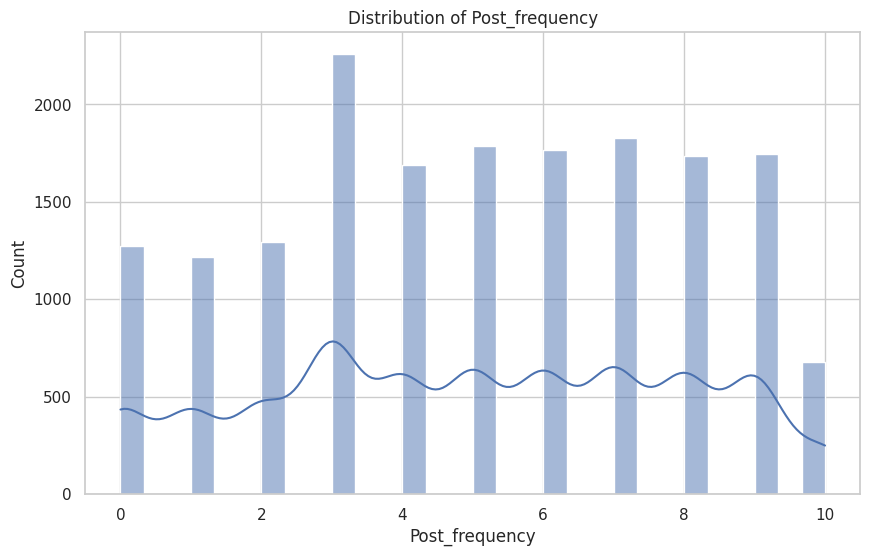

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

numeric_features = train.select_dtypes(include=['float64', 'int64']).columns.drop(['id'])
for col in numeric_features:
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

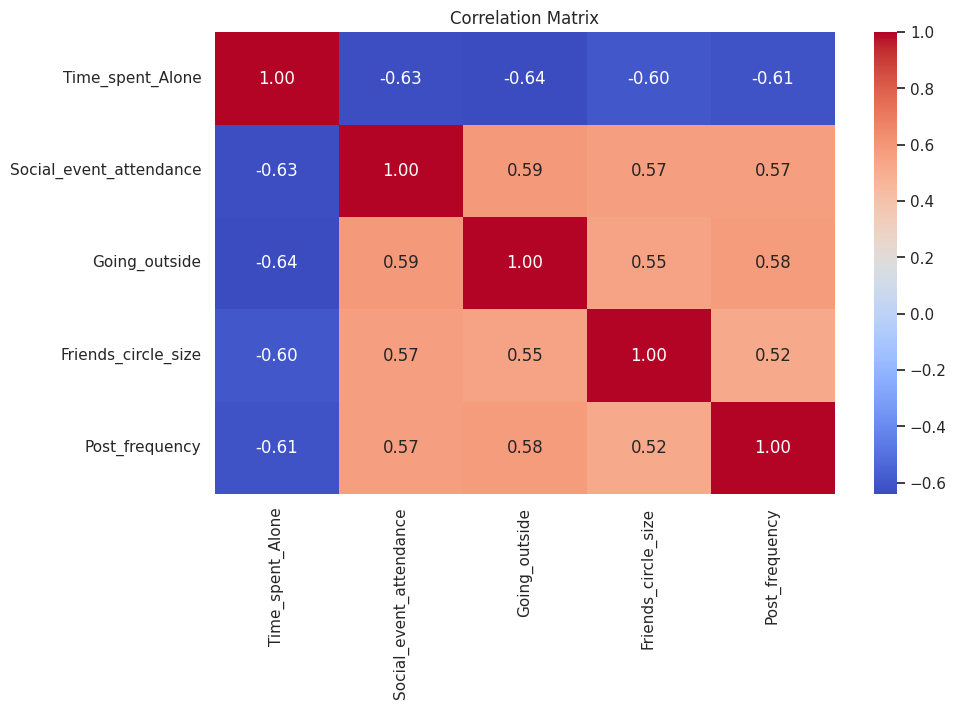

In [9]:
corr_matrix = train[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

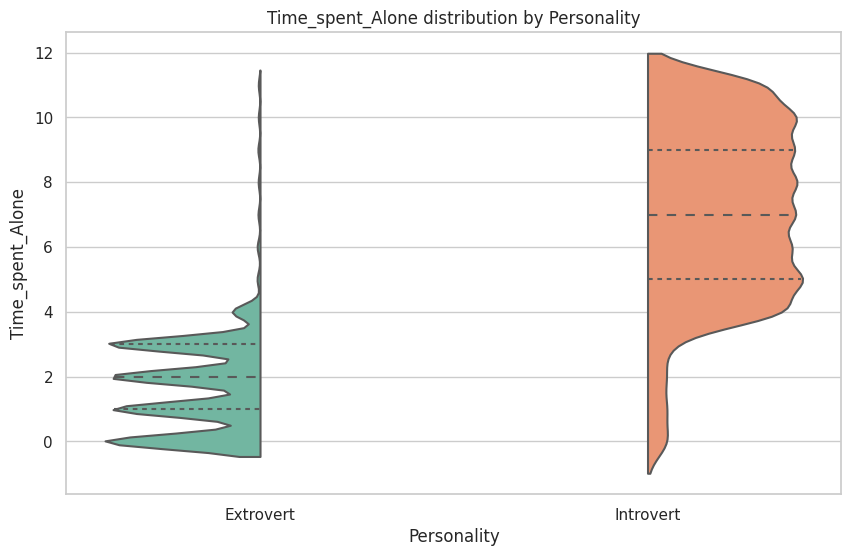

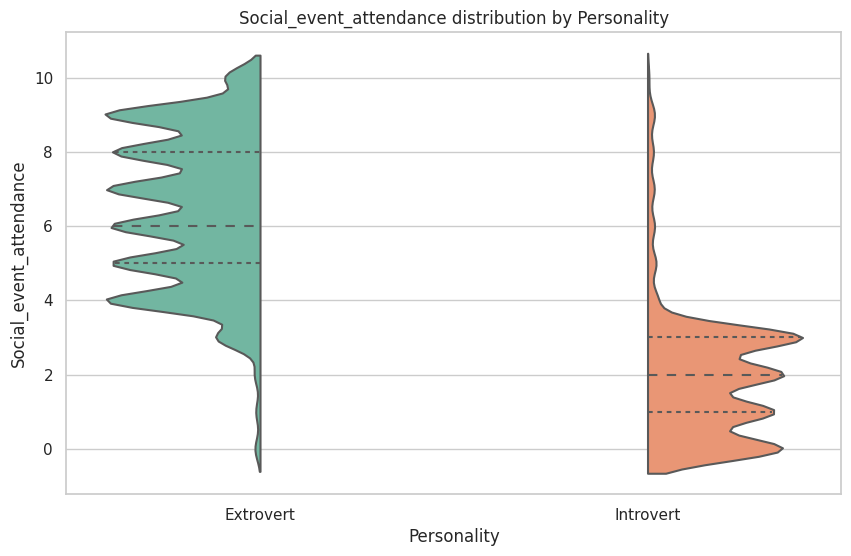

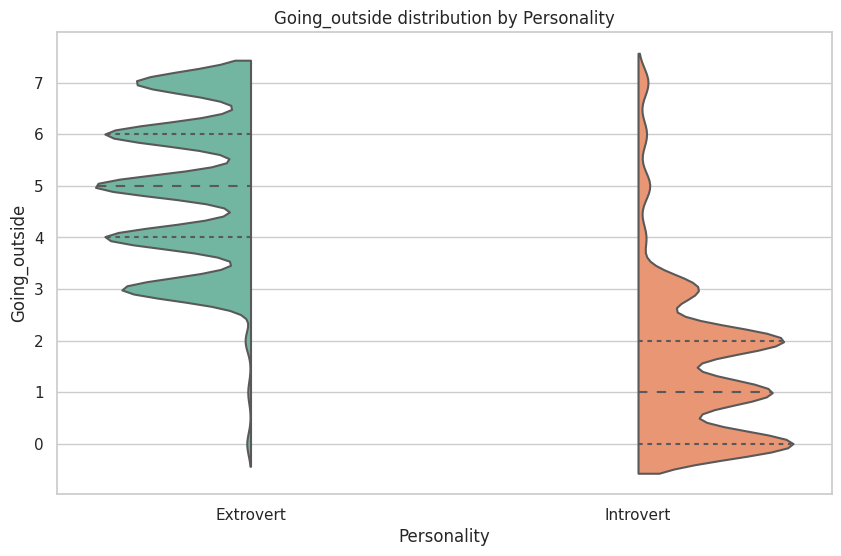

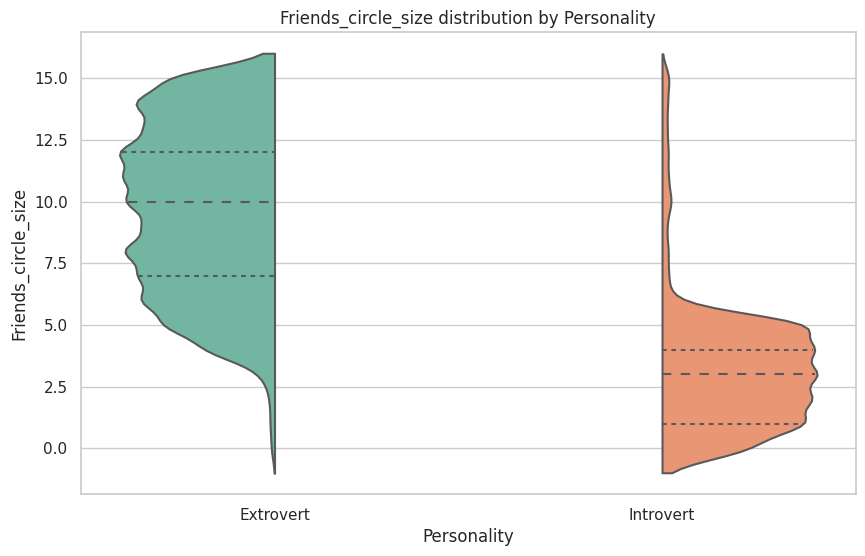

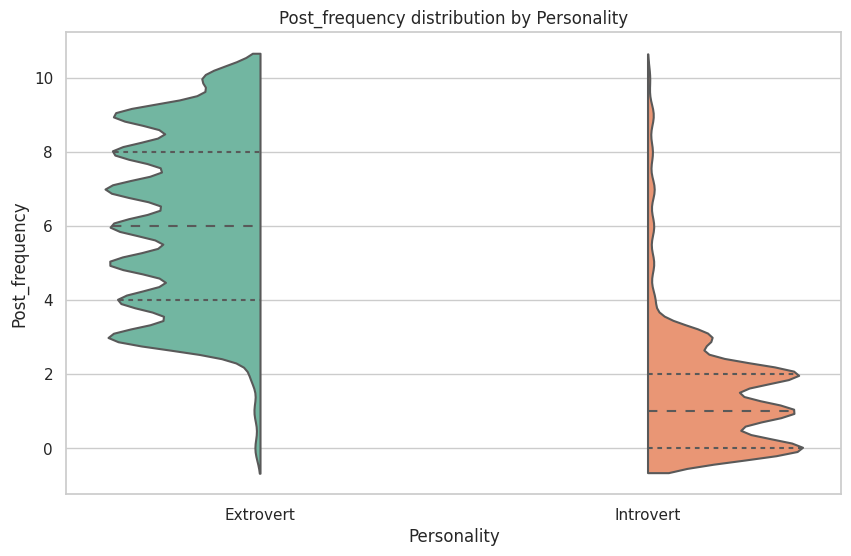

In [10]:
for col in numeric_features:
    sns.violinplot(data=train, x='Personality', y=col, hue='Personality', split=True, inner='quartile', palette='Set2')
    plt.title(f'{col} distribution by Personality')
    plt.xlabel('Personality')
    plt.ylabel(col)
    plt.legend([],[], frameon=False)
    plt.show()

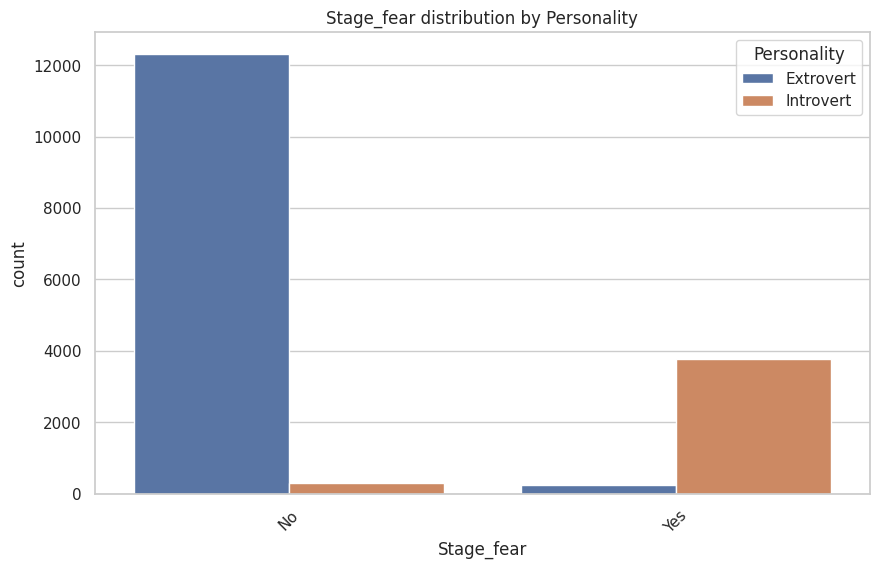

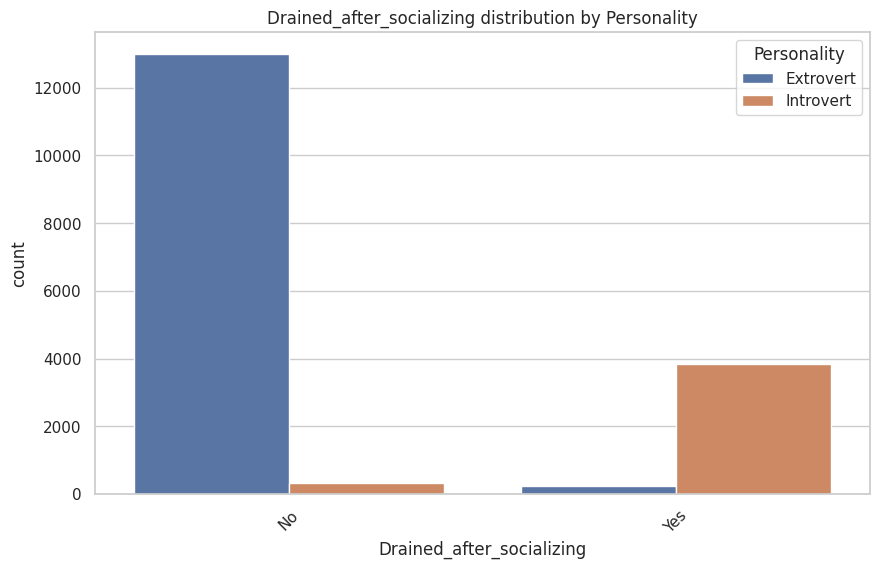

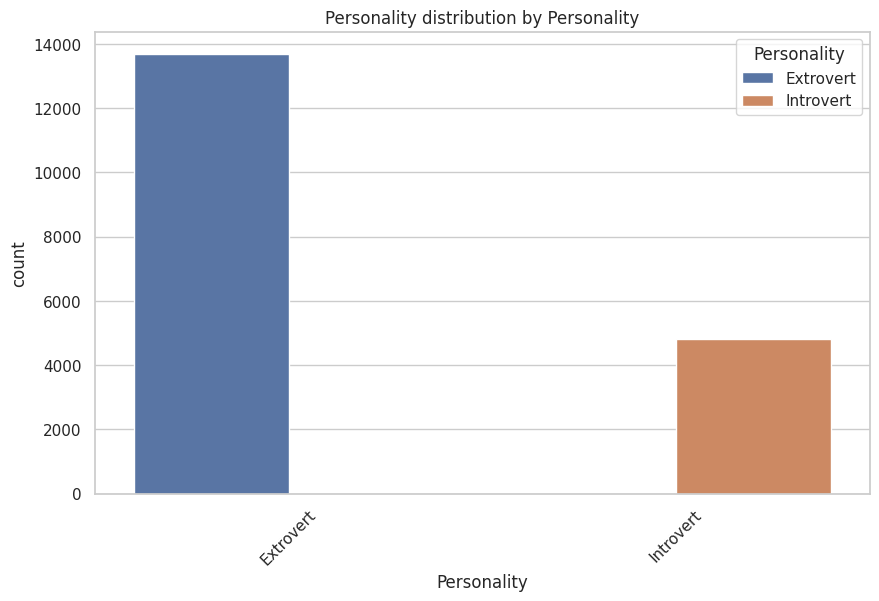

In [11]:
categorical_features = train.select_dtypes(include=['object', 'bool']).columns
for col in categorical_features:
    sns.countplot(data=train, x=col, hue='Personality')
    plt.title(f'{col} distribution by Personality')
    plt.xticks(rotation=45)
    plt.show()

In [12]:
print("Duplicates in train:", train.duplicated().sum())
print("Duplicates in test:", test.duplicated().sum())

Duplicates in train: 0
Duplicates in test: 0


In [13]:
train = train.drop_duplicates()
print(f"Train shape after removing duplicates: {train.shape}")

Train shape after removing duplicates: (18524, 9)


In [14]:
train_id = train['id']
test_id = test['id']
y = train['Personality']
X_train = train.drop(['id', 'Personality'], axis=1)
X_test = test.drop(['id'], axis=1)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y shape: {y.shape}")


X_train shape: (18524, 7)
X_test shape: (6175, 7)
y shape: (18524,)


In [15]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Numeric features (5): ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Categorical features (2): ['Stage_fear', 'Drained_after_socializing']


In [16]:
# knn_imputer = KNNImputer(n_neighbors=5)
# X_train[numeric_features] = knn_imputer.fit_transform(X_train[numeric_features])
# X_test[numeric_features] = knn_imputer.transform(X_test[numeric_features])
# print("Numeric features imputed using KNNImputer")

In [17]:
iter_imputer = IterativeImputer(random_state=42)
X_train[numeric_features] = iter_imputer.fit_transform(X_train[numeric_features])
X_test[numeric_features] = iter_imputer.transform(X_test[numeric_features])
print("Numeric features imputed using IterativeImputer")

Numeric features imputed using IterativeImputer


In [18]:
if len(categorical_features) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_features] = cat_imputer.fit_transform(X_train[categorical_features])
    X_test[categorical_features] = cat_imputer.transform(X_test[categorical_features])
    print("Categorical features imputed with most frequent")

Categorical features imputed with most frequent


In [19]:
# X_train[categorical_features] = X_train[categorical_features].fillna('Missing')
# X_test[categorical_features] = X_test[categorical_features].fillna('Missing')

# print("Stage_fear та Drained_after_socializing заповнені як 'Missing'")

In [20]:
print(f"\nMissing values in X_train after imputation: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test after imputation: {X_test.isnull().sum().sum()}")


Missing values in X_train after imputation: 0
Missing values in X_test after imputation: 0


In [21]:
ordinal_encoder = OrdinalEncoder()
X_train[categorical_features] = ordinal_encoder.fit_transform(X_train[categorical_features])
X_test[categorical_features] = ordinal_encoder.transform(X_test[categorical_features])
print("Categorical features encoded using OrdinalEncoder")

Categorical features encoded using OrdinalEncoder


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("All features scaled using StandardScaler")

All features scaled using StandardScaler


In [23]:
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Target classes: {target_encoder.classes_}")
print(f"Target encoding: {dict(zip(target_encoder.classes_, range(len(target_encoder.classes_))))}")
print(f"Class distribution: {dict(zip(target_encoder.classes_, np.bincount(y_encoded)))}")

Target classes: ['Extrovert' 'Introvert']
Target encoding: {'Extrovert': 0, 'Introvert': 1}
Class distribution: {'Extrovert': 13699, 'Introvert': 4825}


In [24]:
class_labels = np.unique(y_encoded)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_encoded)
class_weight_dict = dict(zip(class_labels, class_weights))
print("Class weights computed for imbalance compensation:")
print(class_weight_dict)

Class weights computed for imbalance compensation:
{0: 0.6761077450908826, 1: 1.9195854922279794}


In [25]:
print(f"\nFinal X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")
print(f"Final y_encoded shape: {y_encoded.shape}")
print(f"\nData types in X_train:\n{X_train.dtypes.value_counts()}")
print(f"\nData types in X_test:\n{X_test.dtypes.value_counts()}")


Final X_train shape: (18524, 7)
Final X_test shape: (6175, 7)
Final y_encoded shape: (18524,)

Data types in X_train:
float64    7
Name: count, dtype: int64

Data types in X_test:
float64    7
Name: count, dtype: int64


In [26]:
# import os
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from sklearn.model_selection import train_test_split

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train_scaled, y_encoded,
#     test_size=0.3,
#     random_state=42,
#     stratify=y_encoded
# )

# model = Sequential([
#     Input(shape=(X_tr.shape[1],)),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

# early_stop = EarlyStopping(patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# history = model.fit(
#     X_tr, y_tr,
#     validation_data=(X_val, y_val),
#     epochs=30,
#     batch_size=16,
#     callbacks=[early_stop, checkpoint],
#     class_weight=class_weight_dict
# )

# y_pred_proba = model.predict(X_test_scaled)
# y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# y_pred_labels = target_encoder.inverse_transform(y_pred)

# submission = pd.DataFrame({
#     'id': test_id,
#     'Personality': y_pred_labels
# })
# submission.to_csv('submission.csv', index=False)
# print("Submission saved to submission.csv")

In [27]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

model = Sequential([
    Input(shape=(X_tr.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

y_pred_labels = target_encoder.inverse_transform(y_pred)

submission = pd.DataFrame({
    'id': test_id,
    'Personality': y_pred_labels
})
submission.to_csv('submission.csv', index=False)

2025-11-14 06:48:32.363336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763102912.609423      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763102912.674175      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/30


2025-11-14 06:48:47.083847: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


927/927 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9481 - auc: 0.9525 - loss: 0.2086 - val_accuracy: 0.9711 - val_auc: 0.9709 - val_loss: 0.1309 - learning_rate: 0.0010
Epoch 2/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9659 - auc: 0.9598 - loss: 0.1521 - val_accuracy: 0.9711 - val_auc: 0.9734 - val_loss: 0.1227 - learning_rate: 0.0010
Epoch 3/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9696 - auc: 0.9664 - loss: 0.1382 - val_accuracy: 0.9711 - val_auc: 0.9667 - val_loss: 0.1259 - learning_rate: 0.0010
Epoch 4/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9675 - auc: 0.9652 - loss: 0.1433 - val_accuracy: 0.9714 - val_auc: 0.9742 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 5/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9666 - auc: 0.9630 - loss: 0.1461 - val_accuracy: 0.9714 - val_auc: 0.9687 - val_loss: 0.1243 - learning_rate: 0.0010
Epoch 6/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9704 - auc: 0.9652 - loss

In [28]:
pd.read_csv('submission.csv').head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
